<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_1/practice_3_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Вспомогательный код
*Запустите клетку ниже перед началом работы*

In [1]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from sklearn.metrics import accuracy_score


%matplotlib inline
np.random.seed(10)

colors = ['red', "blue"]
labels_cmap = ListedColormap(colors, 2)
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
main_cmap = LinearSegmentedColormap.from_list("main_scheme", colors, N=300)

def show_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], s=120, color=labels_cmap(y))
    
def generate_simple_data(N, a, b, c, max_x=5, max_y=5):
    np.random.seed(10)
    X = np.random.rand(N, 2)
    X[:, 0] = X[:, 0] * max_x
    X[:, 1] = X[:, 1] * max_y
    y = np.zeros(N)
    y[X[:, 0] * a + X[:, 1] * b + c > 0] = 1
    #y[X[:, 0] * a + X[:, 1] * b + c < -m]= 0
    return X, y

def show_descision_boundary(clf, limits, binary=False, X=None, y=None, n_lines=10, show_lines=False,
                           figsize=(5, 5), ax=None):
    xs, ys = limits
    x_min, x_max = xs
    y_min, y_max = ys
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
    
    if binary:
        Z = clf.predict_class(np.c_[xx.ravel(), yy.ravel()])
        norm = Normalize(vmin=0.,vmax=1.)
    else:
        Z = clf(np.c_[xx.ravel(), yy.ravel()])
        if clf.prob_output:
            norm = Normalize(vmin=0.,vmax=1.)
        else:
            norm = Normalize(vmin=-10.,vmax=10., clip=True)
        
    Z = Z.reshape(xx.shape)
    Z = Z.astype(np.float32)
    
    ax.contourf(xx, yy, Z, n_lines, alpha=0.4, cmap=main_cmap, norm=norm)
    if show_lines:
        cp = ax.contour(xx, yy, Z, n_lines)
        ax.clabel(cp, inline=True, 
              fontsize=10, colors="green")
    
    if y is not None:
        X = np.array(X)
        y = np.array(y)
        ax.scatter(X[:, 0], X[:, 1], s=120, color=labels_cmap(y),
                   zorder=4)
        

def eval_clf(clf, X, y):
    acc = accuracy_score(clf.predict_class(X), y)
    print(f"Accuracy {acc}")
    return acc

def create_three_axes():
    fig = plt.figure(figsize=(16, 5))
    grid = plt.GridSpec(1, 3)
    logits = fig.add_subplot(grid[0, 0])
    logits.set_xlabel("$x_1$")
    logits.set_ylabel("$x_2$")
    logits.set_title("Логит класса 1 (синий)")
    
    probs = fig.add_subplot(grid[0, 1])
    probs.set_xlabel("$x_1$")
    probs.set_ylabel("$x_2$")
    probs.set_title("Вероятность класса 1 (синий)")

    binary = fig.add_subplot(grid[0, 2])
    binary.set_xlabel("$x_1$")
    binary.set_ylabel("$x_2$")
    binary.set_title("Решающая поверхность")
    
    return logits, probs, binary


# Ваш первый нейрон

В этом практическом задании, вы реализуете класс, описывающий нейрон с нуля. Убедитесь, что вы точно правильно понимаете, что такое логит-модели, вероятности и связь между ними. 

Логистическая регрессия или логит-модель — статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой. Эта регреcсия выдаёт ответ в виде вероятности бинарного события (1 или 0).

Начнем с реализации сигмоиды. Должно получится вот так:

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1920px-Logistic-curve.svg.png width="400">

Tests passed


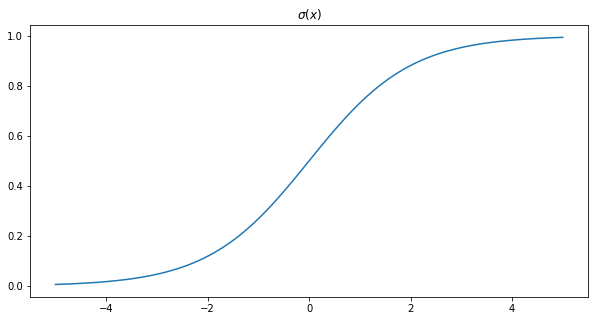

In [2]:
def sigmoid(x):
    # реализуйте сигмоиду 1./(1 + exp(-x))
    value = None

    # < YOUR CODE STARTS HERE >
    # value должна содержать выход сигмоиды
    value = 1. / (1 + np.exp(-x))
    # < YOUR CODE ENDS HERE >
    
    return value
    

plt.figure(figsize=(10, 5))
plt.title("$\sigma(x)$")
xs = np.linspace(-5, 5, 100)
_ = plt.plot(xs, sigmoid(xs))

for x, y in zip([-5, 0, 5], [0.006, 0.5, 0.993]):
    assert np.allclose(sigmoid(x), y, atol=1e-3), f"Value at {x} is {sigmoid(x)}, but {y} is expected"
print("Tests passed")

In [50]:
class Neuron:
    """
    Класс, реализующий нейрон
    """
    def __init__(self, a: float, b: float, c: float, prob_output: bool = True):
        """
        a,b,c -- коэффиценты (веса) нейрона
        prob_output -- если True, то, на выходе -- вероятности, если False -- логит

        """
        self.a = a
        self.b = b
        self.c = c
        self.prob_output = prob_output

    def calculate_logit(self, x: np.ndarray) -> np.ndarray:
        """
        x -- массив размера (N, 2), где N -- количество объектов. 
             Первый столбец -- признак  x1, второй -- x2.

        Данный метод должен возвращать logit = a*x1 + b*x2 + c

        """  
        assert np.ndim(x) == 2 and x.shape[1] == 2
        logit = None
        # < YOUR CODE STARTS HERE >
        # переменная logit должна содержать логит, как описано в комментарии к функции
        logit = self.a * x[:, 0] + self.b * x[:, 1] + self.c
        # < YOUR CODE ENDS HERE >
        
        return logit

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """
        x -- массив размера (N, 2), где N -- количество объектов. 
             Первый столбец -- признак  x1, второй -- x2.

        Данный метод должен возвращать logit(x), если self.prob_output=False,
        и sigmoid(logit(x)) иначе
        
        """  
        assert np.ndim(x) == 2 and x.shape[1] == 2

        # < YOUR CODE STARTS HERE >
        # переменная output должна содежать logit(x), если self.prob_output = False
        # и sigmoid(logit(x)) иначе
        #output = None
        output = self.calculate_logit(x)
        if self.prob_output == True:
          output = sigmoid(output)
        # < YOUR CODE ENDS HERE >

        assert output.shape == (x.shape[0],), f"Output size must have following shape: {[x.shape[0],]}. Recieved: {output.shape}"
        return output
    
    def predict_class(self, x: np.ndarray) -> np.ndarray:
        """
        x -- массив размера (N, 2), где N -- количество объектов. 
             Первый столбец -- признак  x1, второй -- x2.

        Данный метод должен возвращать предсказанный класс для 
        каждого из N объектов -- 0 или 1.

        """
        # < YOUR CODE STARTS HERE >
        logit = self.calculate_logit(x)
        predicted_classes = (logit > 0).astype(int)
        # < YOUR CODE ENDS HERE >

        assert predicted_classes.shape == (x.shape[0],), f"Output size must have following shape: {[x.shape[0],]}. Recieved: {output.shape}"
        return predicted_classes

    def __repr__(self):
        return f"Neuron description. Weights: a={self.a}, b={self.b}. Bias: c={self.c}."

In [51]:
# пользоваться нейроном можно следующим образом:

x_random = np.random.rand(5, 2) # случайные данные

neuron_sigmoid = Neuron(1, -1, 0, prob_output=True) # нейрон, на выходе которого вероятность
neuron_logit = Neuron(1, -1, 0, prob_output=False) # нейрон, на выходе которого логит

probabilities = neuron_sigmoid(x_random)
logits = neuron_logit(x_random)
print(neuron_logit) # выведем описание нейрона
print(f"Logits: {logits}") # предсказанные логиты
print(f"Probabilities: {probabilities}") # предсказанные вероятности
print(f"Classes: {neuron_logit.predict_class(x_random)}") # предсказанные классы

# два нейрона имеют одинаковые параметры, значит предсказанные классы должны совпадать
classes_1 = neuron_logit.predict_class(x_random)
classes_2 = neuron_sigmoid.predict_class(x_random)
assert np.alltrue( classes_1 == classes_2) 

Neuron description. Weights: a=1, b=-1. Bias: c=0.
Logits: [ 0.18233427 -0.91456809 -0.15534079  0.5363069  -0.20152418]
Probabilities: [0.5454577  0.28606598 0.46124271 0.63095289 0.44978877]
Classes: [1 0 0 1 0]


Ниже можно увидеть знакомые вам визуализации, но теперь они получены нейроном, полностью реализованным вами. Если все сделано правильно, то во всех трех случаях точность будет 100%.

Accuracy 1.0
Accuracy 1.0
Accuracy 1.0


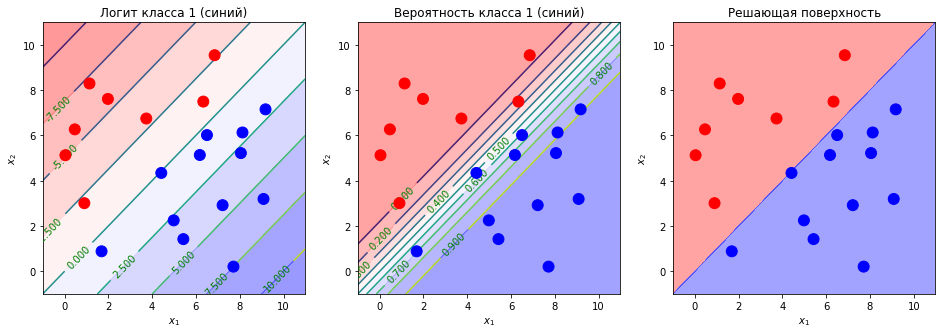

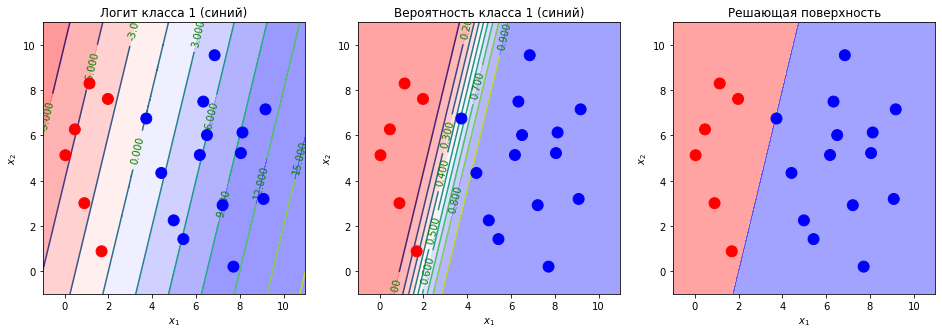

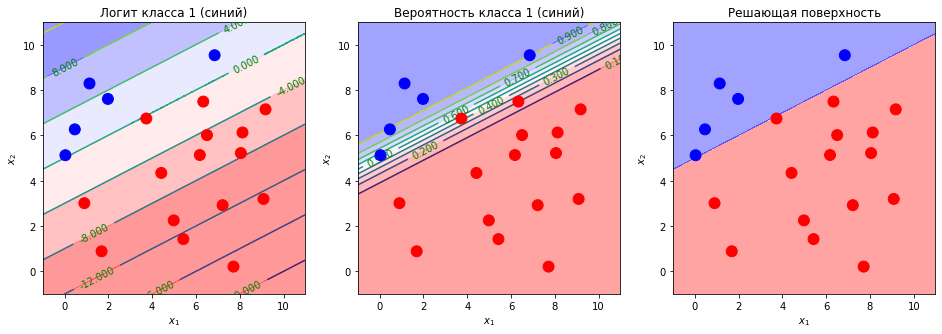

In [41]:
n_lines = 10
limits = [[-1, 11], [-1, 11]]
for i, params in enumerate([[1, -1, 0], [2, -0.5, -4], [-1, 2, -10] ]):
    a, b, c = params
    clf_logits = Neuron(a, b, c, False)
    clf_probs = Neuron(a, b, c, True)
    
    X, y = generate_simple_data(20, a, b, c, 10, 10)

    logits, probs, classes = create_three_axes()

    show_descision_boundary(limits=limits, clf=clf_logits, 
                                X=X,
                                y=y, 
                                n_lines=n_lines,
                                show_lines=True, ax=logits)
    
    show_descision_boundary(limits=limits, clf=clf_probs, 
                                X=X,
                                y=y, 
                                n_lines=n_lines,
                                show_lines=True, ax=probs)
    
    show_descision_boundary(limits=limits, clf=clf_logits, binary=True,
                                X=X,
                                y=y, 
                                n_lines=n_lines,
                                show_lines=False, ax=classes)

    acc = eval_clf(clf_logits, X, y)
